This notebook is following the direction and notes of: https://github.com/prateekjoshi565/movie_genre_prediction/blob/master/Movie_Genre_Prediction.ipynb

We will start by importing the required libraries. 

In [1]:
import pandas as pd
import numpy as np
import json
import nltk
import re
import csv
import matplotlib.pyplot as plt 
import seaborn as sns
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

%matplotlib inline
pd.set_option('display.max_colwidth', 300)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Load Data


In [2]:
import pandas as pd
df = pd.read_csv('https://raw.githubusercontent.com/Lambda-School-Labs/Labs25-Human_Rights_First-TeamC-DS/main/Data/training_data.csv', na_values=False)

In [3]:
df = df.drop(columns=df.columns[0])
df.head()

,date_text,text,tags_str,LATITUDE,LONGITUDE,Link 1,Link 2
0,June 3rd,Police throw tear-gas at protesters on a bridge.,Projectiles,29.963071,-90.160953,https://twitter.com/misaacstein/status/1268381797081022464,https://twitter.com/ckm_news/status/1268382403367763970
1,June 3rd,Police throw tear-gas at protesters on a bridge.,Projectiles,29.960484,-90.075301,https://twitter.com/misaacstein/status/1268381797081022464,https://twitter.com/ckm_news/status/1268382403367763970
2,May 30th,Police assault protesters,EHC Hard Technique,30.210692,-97.942749,https://gfycat.com/tautimaginativedore,https://www.reddit.com/r/2020PoliceBrutality/comments/hhhbeh/5302020_austin/
3,May 30th,Police assault protesters,EHC Hard Technique,30.230300,-97.714400,https://gfycat.com/tautimaginativedore,https://www.reddit.com/r/2020PoliceBrutality/comments/hhhbeh/5302020_austin/
4,May 30th,Police assault protesters,EHC Hard Technique,30.505972,-97.747187,https://gfycat.com/tautimaginativedore,https://www.reddit.com/r/2020PoliceBrutality/comments/hhhbeh/5302020_austin/


In [4]:
# change datatype of 'movie_id'
df['text'] = df['text'].astype(str)
df['tags_str'] = df['tags_str'].astype(str)


In [5]:
df['tags_str'][0]

'Projectiles'

In [6]:
print((df['tags_str'][0]))
print(df['tags_str'][:5])

Projectiles
0           Projectiles
1           Projectiles
2    EHC Hard Technique
3    EHC Hard Technique
4    EHC Hard Technique
Name: tags_str, dtype: object


In [7]:
def tags_cleaner(text):
  # remove whitespaces
    text = ' '.join(text.split())
    # convert text to lowercase
    text = text.lower()
    
    return text



df['tags_new_clean'] = df['tags_str'].apply(lambda x: tags_cleaner(x))

In [8]:
df['tags_new'] = df['tags_new_clean'].apply(lambda x: x.split(', '))
df.tags_new

0                 [projectiles]
1                 [projectiles]
2          [ehc hard technique]
3          [ehc hard technique]
4          [ehc hard technique]
                 ...           
1698    [projectiles, chemical]
1699       [ehc soft technique]
1700       [ehc soft technique]
1701       [ehc soft technique]
1702       [ehc soft technique]
Name: tags_new, Length: 1703, dtype: object

If you are curious to know which all movie genres have been covered in this dataset, then the following code will be useful for you.

In [9]:
df.head(5)

,date_text,text,tags_str,LATITUDE,LONGITUDE,Link 1,Link 2,tags_new_clean,tags_new
0,June 3rd,Police throw tear-gas at protesters on a bridge.,Projectiles,29.963071,-90.160953,https://twitter.com/misaacstein/status/1268381797081022464,https://twitter.com/ckm_news/status/1268382403367763970,projectiles,[projectiles]
1,June 3rd,Police throw tear-gas at protesters on a bridge.,Projectiles,29.960484,-90.075301,https://twitter.com/misaacstein/status/1268381797081022464,https://twitter.com/ckm_news/status/1268382403367763970,projectiles,[projectiles]
2,May 30th,Police assault protesters,EHC Hard Technique,30.210692,-97.942749,https://gfycat.com/tautimaginativedore,https://www.reddit.com/r/2020PoliceBrutality/comments/hhhbeh/5302020_austin/,ehc hard technique,[ehc hard technique]
3,May 30th,Police assault protesters,EHC Hard Technique,30.230300,-97.714400,https://gfycat.com/tautimaginativedore,https://www.reddit.com/r/2020PoliceBrutality/comments/hhhbeh/5302020_austin/,ehc hard technique,[ehc hard technique]
4,May 30th,Police assault protesters,EHC Hard Technique,30.505972,-97.747187,https://gfycat.com/tautimaginativedore,https://www.reddit.com/r/2020PoliceBrutality/comments/hhhbeh/5302020_austin/,ehc hard technique,[ehc hard technique]


In [10]:
# get all genre tags in a list
tags = []

for i in df['tags_str']:
  tags.append(i)



print(len(set(tags)))
print(set(tags))

26
{'EHC Soft Technique, EHC Hard Technique, Projectiles, Chemical', 'EHC Soft Technique', 'Verbalization', 'Conductive Energy', 'EHC Soft Technique, EHC Hard Technique, Blunt Impact, Projectiles, Chemical', 'EHC Hard Technique', 'Verbalization, EHC Soft Technique', 'EHC Soft Technique, Projectiles, Chemical', 'EHC Soft Technique, EHC Hard Technique', 'Blunt Impact', 'Blunt Impact, Projectiles', 'Presence', 'Projectiles', 'EHC Soft Technique, Projectiles', 'Other', 'EHC Hard Technique, Projectiles, Chemical', 'EHC Hard Technique, Blunt Impact, Projectiles, Chemical', 'EHC Soft Technique, EHC Hard Technique, Projectiles', 'Presence, EHC Hard Technique', 'Presence, Projectiles', 'Blunt Impact, Projectiles, Chemical', 'Projectiles, Chemical', 'EHC Hard Technique, Blunt Impact', 'Projectiles, Conductive Energy', 'EHC Soft Technique, Blunt Impact', 'EHC Soft Technique, EHC Hard Technique, Blunt Impact, Projectiles'}


In [11]:
tags = nltk.FreqDist(tags)
tags_df = pd.DataFrame({'Tags': list(tags.keys()), 'Count': list(tags.values())})

Sometimes visualizing data is better than putting out numbers. Let's plot the distribution of the tags.

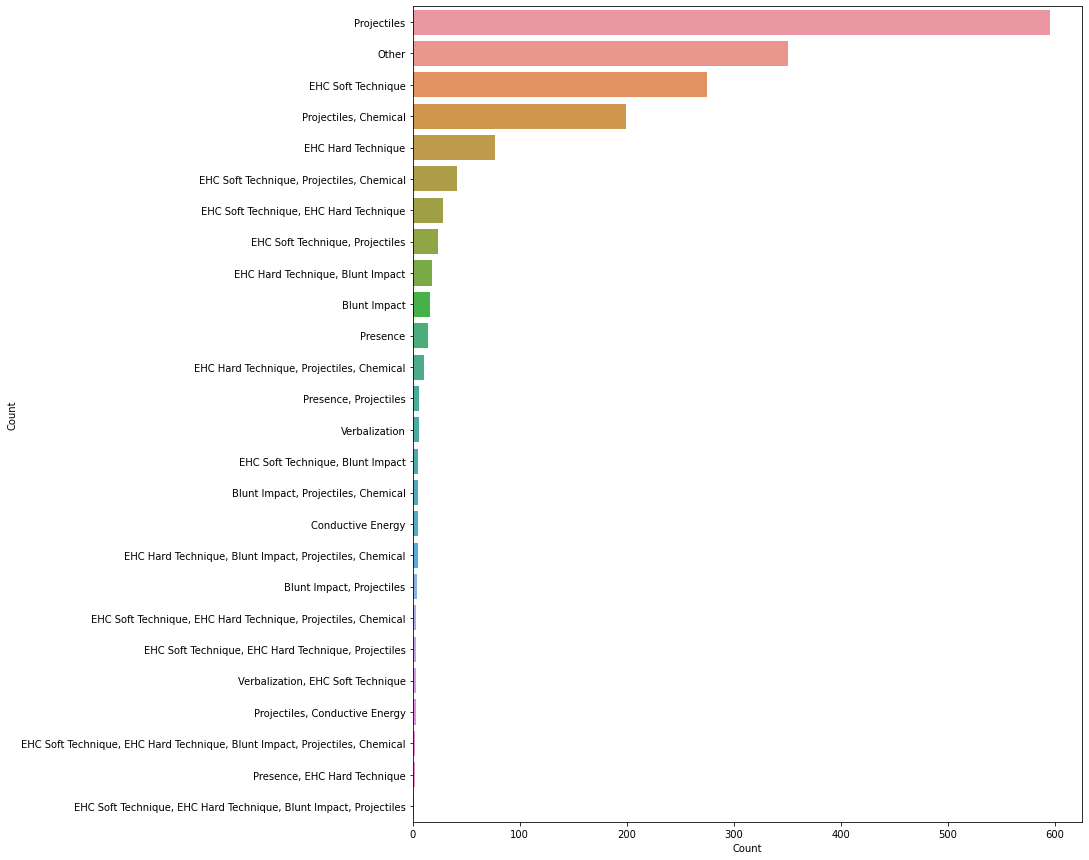

In [12]:
g = tags_df.nlargest(columns="Count", n = 50) 
plt.figure(figsize=(12,15))
ax = sns.barplot(data=g, x= "Count", y = "Tags")
ax.set(ylabel = 'Count')
plt.show()

 Basic text cleaning steps..


In [13]:
# function for text cleaning
def clean_text(text):
    # remove backslash-apostrophe
    text = re.sub("\'", "", text)
    # remove everything alphabets
    text = re.sub("[^a-zA-Z]"," ",text)
    # remove whitespaces
    text = ' '.join(text.split())
    # convert text to lowercase
    text = text.lower()
    
    return text

Apply the function on the new text by using the apply-lambda duo.

In [14]:
df['new_text'] = df['text'].apply(lambda x: clean_text(x))

In [15]:
df[['text', 'new_text']].sample(5)

,text,new_text
1151,Woman shot in hand by wooden bullet,woman shot in hand by wooden bullet
1298,Police pepper spray BLM counter-protesters at pro-police rally,police pepper spray blm counter protesters at pro police rally
1564,Police officer stops abrubtly so protester bumps into him; police arrest him after this,police officer stops abrubtly so protester bumps into him police arrest him after this
1461,CNN Reporter arrested,cnn reporter arrested
100,Officer pepper-sprays protester,officer pepper sprays protester


In [16]:
def freq_words(x, terms = 30):
  all_words = ' '.join([text for text in x])
  all_words = all_words.split()
  
  fdist = nltk.FreqDist(all_words)
  words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})
  
  # selecting top 20 most frequent words
  d = words_df.nlargest(columns="count", n = terms) 
  plt.figure(figsize=(8,12))
  ax = sns.barplot(data=d, x= "count", y = "word")
  ax.set(ylabel = 'Word')
  plt.show()

In [17]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Remove the stopwords.

In [18]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

# function to remove stopwords
def remove_stopwords(text):
    no_stopword_text = [w for w in text.split() if not w in stop_words]
    return ' '.join(no_stopword_text)
  
df['new_text'] = df['new_text'].apply(lambda x: remove_stopwords(x))

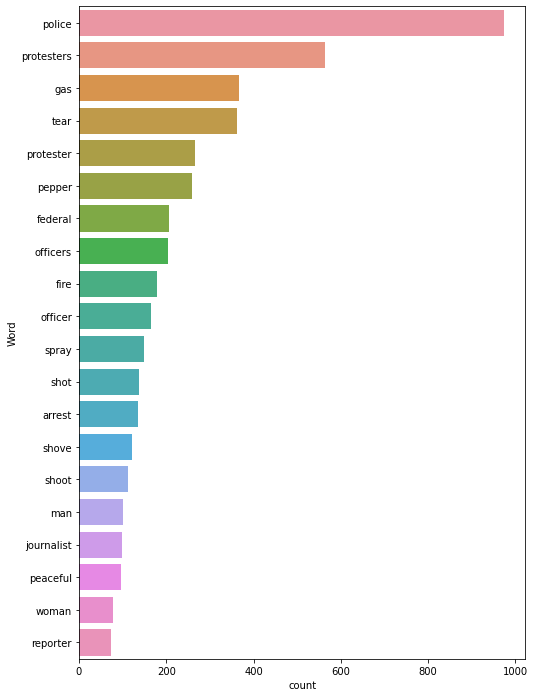

In [19]:
freq_words(df['new_text'], 20)

### Converting Text to Features

I will treat this multilable classification problem as a Binary Relevance problem. Hence, now I am going to one hot encode the target variable, i.e. *tags_new* by using sklearn's **MultiLabelBinarizer( )**. Since there are 26 unique  tags, there are going to be 26 new target variables.


In [20]:
from sklearn.preprocessing import MultiLabelBinarizer

multilabel_binarizer = MultiLabelBinarizer()

multilabel_binarizer.fit(df['tags_new'])
print(multilabel_binarizer.classes_)

# transform target variable

y = multilabel_binarizer.transform(df['tags_new'])

['blunt impact' 'chemical' 'conductive energy' 'ehc hard technique'
 'ehc soft technique' 'other' 'presence' 'projectiles' 'verbalization']


In [21]:
print(y.shape)

(1703, 9)


We have successfully transformed the target variable and now let's turn our focus to extract features from the cleaned version of the df text. I have decided to use TF-IDF features. Any other feature extraction method such as Bag-of-Words, word2vec, GloVe, or ELMo would work. 

Learn more about different ways of creating features from text:

*   [An Intuitive Understanding of Word Embeddings: From Count Vectors to Word2Vec](https://www.analyticsvidhya.com/blog/2017/06/word-embeddings-count-word2veec/)
*   [A Step-by-Step NLP Guide to Learn ELMo for Extracting Features from Text](https://www.analyticsvidhya.com/blog/2019/03/learn-to-use-elmo-to-extract-features-from-text/)



In [22]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=10000)

Please note that I have used the 10,000 most frequent words in the data as my features. You can try any other number as well for the parameter max_features. Before creating TF-IDF features, we will split our data into train and validation sets for training our and evaluating its performance, respectively. 80% of the data samples have been kept in the train set and the rest of the data is in the validation set.

In [23]:
# split dataset into training and validation set
xtrain, xval, ytrain, yval = train_test_split(df['new_text'], y, test_size=0.2, random_state=9)

Now we can create features for the train and the validation set.

In [24]:
# create TF-IDF features
xtrain_tfidf = tfidf_vectorizer.fit_transform(xtrain)
xval_tfidf = tfidf_vectorizer.transform(xval)

### Build the Category Prediction Model

As we have already discussed earlier, if we are using the Binary Relevance approach to solve a multilable problem, then we will have to one hot encode the target variable and then build model for each and every one hot encoded target variables. Since we have 26 target variables, we will have to fit 26 different models with the same set of predictors (TF-IDF features). 

Training 26 models can take a considerable amount of time on a modest system. Hence, I will go ahead with the Logistic Regression model as it is quick to train and easy on the limited hardware.

In [25]:
from sklearn.linear_model import LogisticRegression

# Binary Relevance
from sklearn.multiclass import OneVsRestClassifier

# Performance metric
from sklearn.metrics import f1_score

We will use sklearn's OneVsRestClassifier class to solve this problem as a Binary Relevance or one-vs-all problem.

In [26]:
lr = LogisticRegression()
clf = OneVsRestClassifier(lr)

Finally we are going to fit our model on the train set

In [27]:
# fit model on train data
clf.fit(xtrain_tfidf, ytrain)

OneVsRestClassifier(estimator=LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=None,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False),
                    n_jobs=None)

Once our model is trained, we can then predict categories for the validation set. Let's do it.

In [28]:
# make predictions for validation set
y_pred = clf.predict(xval_tfidf)

Here is a prediction...

In [29]:
y_pred[9]

array([0, 0, 0, 0, 1, 0, 0, 0, 0])

It is a binary one dimensional array of length 26. Basically it is the one hot encoded form of the unique tags. We will have to find some way to convert it into categories. We will use **inverse_transform( )** function along with the MultiLabelBinarizer( ) object to convert the predicted arrays into tags.

In [30]:
multilabel_binarizer.inverse_transform(y_pred)[9]

('ehc soft technique',)

To evaluate our model's overall performance, we will have to take into consideration all the predictions and the entire target variable of the validation set.

In [31]:
# evaluate performance
f1_score(yval, y_pred, average="micro")

0.9041769041769041

In [32]:
# predict probabilities
y_pred_prob = clf.predict_proba(xval_tfidf)

Now set a threshold value.

In [33]:
t = 0.3 # threshold value
y_pred_new = (y_pred_prob >= t).astype(int)

I have tried 0.3 as the threshold value. You may try any other value as well. Let's check the F1 score again on these new predictions.

In [34]:
# evaluate performance
f1_score(yval, y_pred_new, average="micro")

0.9638009049773756

A better approach to find the right threshold value would be to use a k-fold cross validation setup and try different threshold values.

### Create Inference Function

Our job is still not over. We have trained our model and we have also made predictions for the validation set. However, we also have to take care of the new data or that would come in the future. Our prediction system should be able to take a text in raw form as input and give out its category tags as output.

To achieve this objective, let's build an inference function. It will take in a text and follow the steps below:



*   Clean the text
*   Remove stopwords from the cleaned text
*   Extract features from the text
*   Make predictions
*   Return the predicted category tags




In [35]:
def infer_tags(q):
    q = clean_text(q)
    q = remove_stopwords(q)
    q_vec = tfidf_vectorizer.transform([q])
    q_pred = clf.predict(q_vec)
    return multilabel_binarizer.inverse_transform(q_pred)

Let's test this inference function on a few samples from the validation set.

In [36]:
for i in range(10):
    k = xval.sample(1).index[0]
    print("Category of Violence: ", df['text'][k], "\nPredicted category: ", infer_tags(xval[k])), print("Actual tag: ",df['tags_str'][k], "\n")   

Category of Violence:  Federal officers use flashbangs, tear gas and impact munitions to push protesters 
Predicted category:  [('projectiles',)]
Actual tag:  Projectiles 

Category of Violence:  Independent journalist arrested 
Predicted category:  [('ehc soft technique',)]
Actual tag:  EHC Soft Technique 

Category of Violence:  LA Times employee recounts getting shot 
Predicted category:  [('projectiles',)]
Actual tag:  Projectiles 

Category of Violence:  Police throw reporter into fire 
Predicted category:  [('projectiles',)]
Actual tag:  Projectiles 

Category of Violence:  Officers shove press during dispersal order 
Predicted category:  [('ehc soft technique',)]
Actual tag:  Verbalization, EHC Soft Technique 

Category of Violence:  Police abduct woman in unmarked van 
Predicted category:  [()]
Actual tag:  Other 

Category of Violence:  Woman hit with police projectile resumes breathing after CPR, delivered to hospital 
Predicted category:  [()]
Actual tag:  Other 

Category o

In [37]:
df_new = df.copy()


In [38]:
df_new = df_new[['date_text', 'LATITUDE', 'LONGITUDE', 'new_text']]
df_new.head(5)

,date_text,LATITUDE,LONGITUDE,new_text
0,June 3rd,29.963071,-90.160953,police throw tear gas protesters bridge
1,June 3rd,29.960484,-90.075301,police throw tear gas protesters bridge
2,May 30th,30.210692,-97.942749,police assault protesters
3,May 30th,30.230300,-97.714400,police assault protesters
4,May 30th,30.505972,-97.747187,police assault protesters


In [39]:
new__tfidf = tfidf_vectorizer.transform(df_new['new_text'])
y_pred = clf.predict(new__tfidf)

df_new['tag_predicted'] = multilabel_binarizer.inverse_transform(y_pred)

In [40]:
df_new.head(5)

,date_text,LATITUDE,LONGITUDE,new_text,tag_predicted
0,June 3rd,29.963071,-90.160953,police throw tear gas protesters bridge,"(projectiles,)"
1,June 3rd,29.960484,-90.075301,police throw tear gas protesters bridge,"(projectiles,)"
2,May 30th,30.210692,-97.942749,police assault protesters,"(ehc hard technique,)"
3,May 30th,30.230300,-97.714400,police assault protesters,"(ehc hard technique,)"
4,May 30th,30.505972,-97.747187,police assault protesters,"(ehc hard technique,)"
